<a href="https://colab.research.google.com/github/eiglesiasr/NoHelmetNet/blob/main/Talleres/Taller04-pretexto/Taller_4_prueba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Taller 4
- Implementar un modelo CNN o ViT. Puede ser un modelo de alguna librería (Keras) o una implementación “vanilla” de una CNN
- Inventar una tarea de pretexto
- Entrenar en ImageNet

In [1]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
!tar -xf imagenette2-160.tgz


--2025-06-02 17:29:07--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.15.185.230, 52.216.220.48, 52.217.125.0, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.15.185.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99003388 (94M) [application/x-tar]
Saving to: ‘imagenette2-160.tgz.3’

imagenette2-160.tgz 100%[===================>]  94.42M  29.9MB/s    in 3.2s    

2025-06-02 17:29:11 (29.9 MB/s) - ‘imagenette2-160.tgz.3’ saved [99003388/99003388]



In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Cargar imágenes (sin etiquetas originales)
dataset = image_dataset_from_directory(
    "imagenette2-160/train",
    labels=None,
    image_size=(160, 160),
    batch_size=None  # devuelve imágenes individuales
)

# Convertimos el dataset a una lista y normalizamos
images = list(dataset.take(8500))  # tomamos 8500 para entrenamiento rápido
images = tf.stack(images)
images = tf.cast(images, tf.float32) / 255.0

print("Número de imágenes cargadas:", images.shape[0])


2025-06-02 17:29:15.898688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748885356.160761     500 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748885356.236497     500 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 9469 files.


2025-06-02 17:29:27.267671: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Número de imágenes cargadas: 8500


In [3]:
def rotate_images(images):
    rotated_images = []
    labels = []

    for img in images:
        angle = np.random.choice([0, 90, 180, 270])
        if angle == 0:
            rotated = img
            label = 0
        elif angle == 90:
            rotated = tf.image.rot90(img, k=1)
            label = 1
        elif angle == 180:
            rotated = tf.image.rot90(img, k=2)
            label = 2
        else:
            rotated = tf.image.rot90(img, k=3)
            label = 3

        rotated_images.append(rotated)
        labels.append(label)

    return tf.stack(rotated_images), np.array(labels)

# Aplicar rotaciones
x_rot, y_rot = rotate_images(images)

# División en train/test
from sklearn.model_selection import train_test_split
x_rot_np = x_rot.numpy()  # convertir a NumPy
x_train, x_test, y_train, y_test = train_test_split(x_rot_np, y_rot, test_size=0.2, random_state=42)


print("Train:", x_train.shape, "Test:", x_test.shape)


Train: (6800, 160, 160, 3) Test: (1700, 160, 160, 3)


In [4]:
from tensorflow.keras import layers, models

def build_rotation_model():
    inputs = tf.keras.Input(shape=(160, 160, 3))

    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.Flatten()(x)

    x = layers.Dense(128, activation='relu', name='features')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(4, activation='softmax')(x)  # 4 clases: rotación

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Crear modelo
rotation_model = build_rotation_model()
rotation_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 158, 158, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 79, 79, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 77, 77, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 36, 36, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 165888)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ features (Dense)                     │ (None, 128)                 │      21,233,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,327,556 (81.36 MB)

 Trainable params: 21,327,556 (81.36 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
history = rotation_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10,
    batch_size=64
)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - accuracy: 0.3320 - loss: 1.8274 - val_accuracy: 0.4588 - val_loss: 1.2152
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.4370 - loss: 1.2262 - val_accuracy: 0.4871 - val_loss: 1.1737
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.4639 - loss: 1.1769 - val_accuracy: 0.4794 - val_loss: 1.1573
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.4683 - loss: 1.1833 - val_accuracy: 0.4800 - val_loss: 1.1486
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.4677 - loss: 1.1541 - val_accuracy: 0.4694 - val_loss: 1.1401
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.4849 - loss: 1.1317 - val_accuracy: 0.4782 - val_loss: 1.1416
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.5085 - loss: 1.0956 - val_accuracy: 0.4912 - val_loss: 1.1469
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.5423 - loss: 1.0188 - val_accu

In [6]:
# Crear extractor de características desde la capa 'features'
feature_extractor = tf.keras.Model(
    inputs=rotation_model.input,
    outputs=rotation_model.get_layer('features').output
)

# Extraer embeddings del conjunto de entrenamiento y prueba
x_train_feat = feature_extractor.predict(x_train)
x_test_feat = feature_extractor.predict(x_test)

print("Shape de embeddings (train):", x_train_feat.shape)
print("Shape de embeddings (test):", x_test_feat.shape)


213/213 ━━━━━━━━━━━━━━━━━━━━ 71s 328ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 260ms/step
Shape de embeddings (train): (6800, 128)
Shape de embeddings (test): (1700, 128)


In [8]:
# Recargamos las imágenes con etiquetas reales
dataset_labeled = image_dataset_from_directory(
    "imagenette2-160/train",
    labels='inferred',
    image_size=(160, 160),
    shuffle=False,
    batch_size=None  # imágenes individuales
)

# Convertimos a listas para alinear con embeddings
images_labeled = list(dataset_labeled.take(8500))

# Separar imágenes y etiquetas
x_all = tf.stack([img for img, label in images_labeled])
y_all = np.array([label.numpy() for img, label in images_labeled])

# Convertir x_all a NumPy antes del split
x_all = x_all.numpy()

# División en train/test
from sklearn.model_selection import train_test_split
x_train_real, x_test_real, y_train_real, y_test_real = train_test_split(
    x_all, y_all, test_size=0.2, random_state=42
)


Found 9469 files belonging to 10 classes.


In [9]:
# Usar extractor para generar embeddings
x_train_feat = feature_extractor.predict(x_train_real)
x_test_feat = feature_extractor.predict(x_test_real)

# Clasificador
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter=1000)
clf.fit(x_train_feat, y_train_real)

y_pred = clf.predict(x_test_feat)
acc = accuracy_score(y_test_real, y_pred)

print(f"🎯 Precisión en clasificación downstream (Imagenette): {acc:.4f}")


213/213 ━━━━━━━━━━━━━━━━━━━━ 57s 265ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 254ms/step
🎯 Precisión en clasificación downstream (Imagenette): 0.2612


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


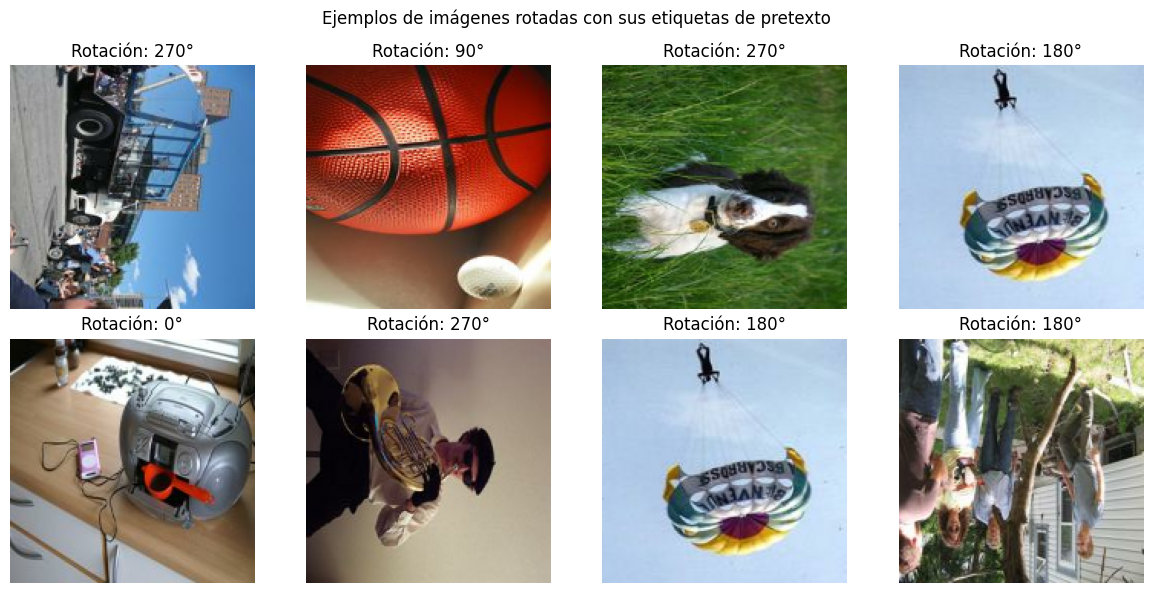

In [10]:
import random
import matplotlib.pyplot as plt

# Mostrar 8 imágenes al azar del conjunto de entrenamiento
plt.figure(figsize=(12, 6))
for i in range(8):
    idx = random.randint(0, len(x_train) - 1)
    img = x_train[idx]
    label = y_train[idx]

    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Rotación: {label * 90}°")
    plt.axis('off')

plt.suptitle("Ejemplos de imágenes rotadas con sus etiquetas de pretexto")
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


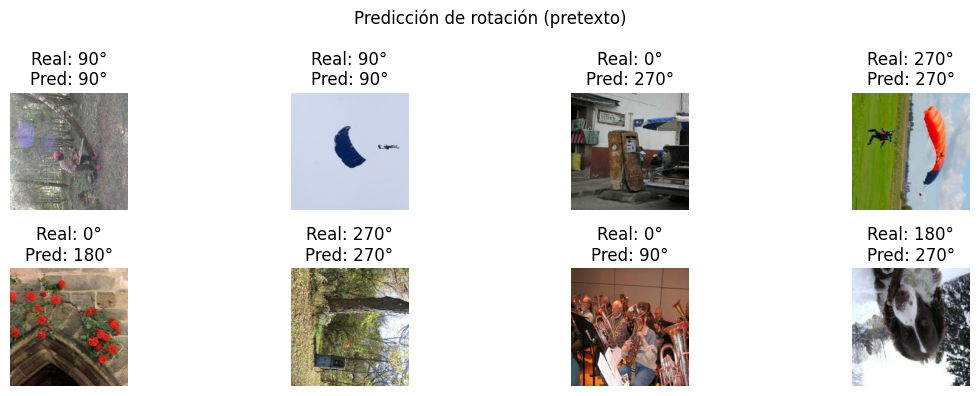

In [11]:
# Predecimos las rotaciones de algunas imágenes de prueba
preds = rotation_model.predict(x_test[:8])
predicted_labels = np.argmax(preds, axis=1)

plt.figure(figsize=(12, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(x_test[i])
    plt.title(f"Real: {y_test[i]*90}°\nPred: {predicted_labels[i]*90}°")
    plt.axis('off')
plt.suptitle("Predicción de rotación (pretexto)")
plt.tight_layout()
plt.show()


54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 266ms/step


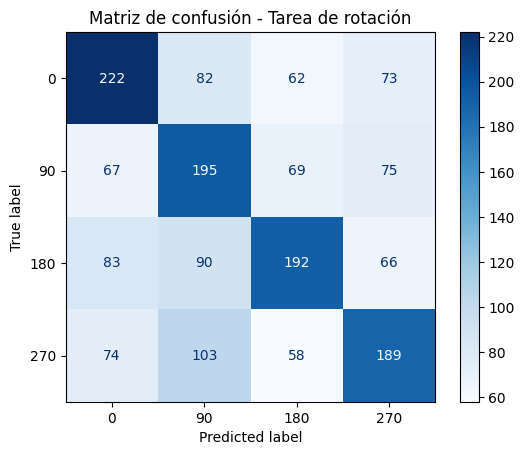

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predicciones
y_pred_rot = np.argmax(rotation_model.predict(x_test), axis=1)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_rot)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 90, 180, 270])
disp.plot(cmap="Blues")
plt.title("Matriz de confusión - Tarea de rotación")
plt.show()


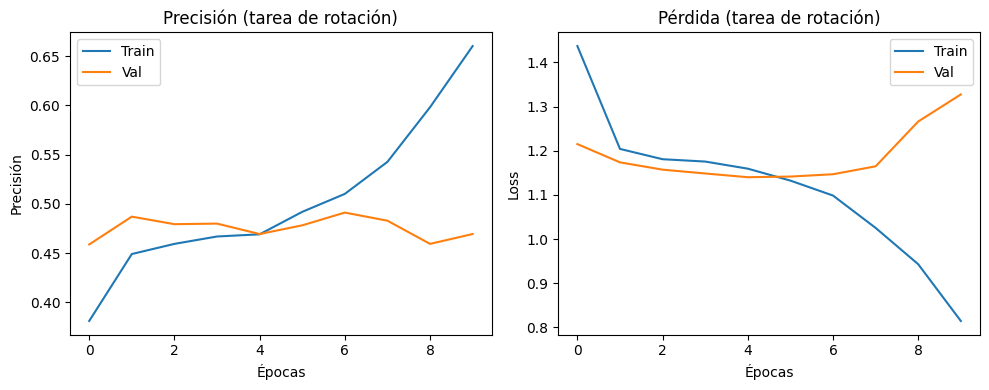

In [ ]:
# Grafica precisión y pérdida del modelo de rotación

plt.figure(figsize=(10, 4))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Precisión (tarea de rotación)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Pérdida (tarea de rotación)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
